In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense, Activation

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime

In [3]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 17351327577055781064]

In [4]:
df = pd.read_csv('data/cswind112610.KS.csv')
df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
1221,2021-03-31,75800.0,77400.0,74100.0,75800.0,75800.0,483643
1222,2021-04-01,76400.0,76800.0,74000.0,74400.0,74400.0,425350
1223,2021-04-02,75000.0,75700.0,71900.0,72000.0,72000.0,571808
1224,2021-04-05,72100.0,73700.0,71200.0,72000.0,72000.0,371545
1225,2021-04-06,72000.0,74400.0,71800.0,73400.0,73400.0,380591


In [5]:
df.dropna(how='any')

,Date,Open,High,Low,Close,Adj Close,Volume
0,2016-04-06,9657.490234,9657.490234,9136.743164,9373.446289,8840.065430,223683
1,2016-04-07,9373.446289,9373.446289,8994.721680,9042.062500,8527.539063,174074
2,2016-04-08,8923.710938,9018.391602,8687.007813,8947.380859,8438.245117,223457
3,2016-04-11,8852.699219,8994.721680,8829.029297,8994.721680,8482.892578,92168
4,2016-04-12,8971.050781,9018.391602,8829.029297,8947.380859,8438.245117,88349
...,...,...,...,...,...,...,...
1221,2021-03-31,75800.000000,77400.000000,74100.000000,75800.000000,75800.000000,483643
1222,2021-04-01,76400.000000,76800.000000,74000.000000,74400.000000,74400.000000,425350
1223,2021-04-02,75000.000000,75700.000000,71900.000000,72000.000000,72000.000000,571808
1224,2021-04-05,72100.000000,73700.000000,71200.000000,72000.000000,72000.000000,371545


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1226 entries, 0 to 1225
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1226 non-null   object 
 1   Open       1226 non-null   float64
 2   High       1226 non-null   float64
 3   Low        1226 non-null   float64
 4   Close      1226 non-null   float64
 5   Adj Close  1226 non-null   float64
 6   Volume     1226 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 67.2+ KB


In [7]:
# 종가 기준으로 구하기
prices = df['Close'].values

In [8]:
prices[-51:-1]

array([87250., 87000., 85500., 83000., 83000., 84250., 80000., 86000.,
       86000., 84500., 83250., 84750., 89600., 92300., 90700., 88500.,
       86100., 83700., 81500., 82000., 77000., 73500., 70000., 72900.,
       72400., 72600., 70400., 66600., 64700., 58600., 61100., 64600.,
       64500., 71000., 69300., 70000., 68400., 69700., 68600., 68100.,
       65800., 69300., 71300., 74700., 74700., 75500., 75800., 74400.,
       72000., 72000.])

In [9]:
# 최근 50일을 기준으로 다음날 가격을 예측을 위한 슬라이싱
seq_len = 50
squence_length = seq_len + 1
result = []
for i in range(len(prices) - squence_length):
    print(i)
    print(prices[i: i + squence_length])
    result.append(prices[i: i + squence_length])
result

0
[ 9373.446289  9042.0625    8947.380859  8994.72168   8947.380859
  9042.0625    9231.424805  8994.72168   8971.050781  8900.040039
  8876.370117  8758.018555  8900.040039  8876.370117  9420.787109
  9420.787109  9775.841797  9799.512695 10556.96289  10722.65527
 10438.61133  10083.55664   9823.182617  9894.193359  9752.171875
  9752.171875  9610.149414  9302.435547  9018.391602  9136.743164
  9018.391602  8923.710938  8876.370117  9397.117188  9184.083984
  9728.500977  9633.820313  9988.875     9965.205078  9610.149414
  9917.864258 10083.55664   9799.512695  9823.182617  9349.776367
  9184.083984  9326.106445  9113.073242  9184.083984  9468.12793
  9491.797852]
1
[ 9042.0625    8947.380859  8994.72168   8947.380859  9042.0625
  9231.424805  8994.72168   8971.050781  8900.040039  8876.370117
  8758.018555  8900.040039  8876.370117  9420.787109  9420.787109
  9775.841797  9799.512695 10556.96289  10722.65527  10438.61133
 10083.55664   9823.182617  9894.193359  9752.171875  9752.171

 13634.10449 13066.0166  12687.29102]
276
[11077.70996 11622.12695 11598.45703 11480.10547 11456.43457 11101.37988
 11219.73145 11125.05078 11172.39063 11148.7207  11030.36914 11409.09375
 11290.74219 11196.06152 11030.36914 11030.36914 10793.66602 11196.06152
 11456.43457 12071.86328 12071.86328 12237.55566 12237.55566 12308.56641
 13326.38965 13302.71973 12947.66504 12923.99414 13042.34668 12261.22559
 12332.23633 12663.62109 12545.26953 12474.25879 12403.24805 12710.96191
 13018.67578 13042.34668 13042.34668 13018.67578 13018.67578 13492.08203
 14959.64258 14699.26856 14202.19141 14249.53223 14154.85156 13634.10449
 13066.0166  12687.29102 13705.11523]
277
[11622.12695 11598.45703 11480.10547 11456.43457 11101.37988 11219.73145
 11125.05078 11172.39063 11148.7207  11030.36914 11409.09375 11290.74219
 11196.06152 11030.36914 11030.36914 10793.66602 11196.06152 11456.43457
 12071.86328 12071.86328 12237.55566 12237.55566 12308.56641 13326.38965
 13302.71973 12947.66504 12923.99414 130

 11243.40234 11740.47852 11527.44531]
360
[12450.58789 11953.51172 11196.06152 11290.74219 11290.74219 11432.76465
 11432.76465 11693.1377  11598.45703 11716.80859 11835.16016 11882.50098
 11882.50098 11977.18164 11929.84082 11574.78613 11787.81934 12237.55566
 12379.57715 13066.0166  13042.34668 12829.31348 12355.90723 12450.58789
 12545.26953 12000.85254 11716.80859 11267.07227 11077.70996 11314.41309
 11456.43457 11243.40234 11219.73145 11645.79688 11669.46777 11598.45703
 11598.45703 11740.47852 12095.5332  12024.52246 12024.52246 12024.52246
 11409.09375 11456.43457 11314.41309 11148.7207  11385.42383 11243.40234
 11740.47852 11527.44531 12000.85254]
361
[11953.51172 11196.06152 11290.74219 11290.74219 11432.76465 11432.76465
 11693.1377  11598.45703 11716.80859 11835.16016 11882.50098 11882.50098
 11977.18164 11929.84082 11574.78613 11787.81934 12237.55566 12379.57715
 13066.0166  13042.34668 12829.31348 12355.90723 12450.58789 12545.26953
 12000.85254 11716.80859 11267.07227 110

 12876.6543  12876.6543  13137.02734]
632
[14557.24707 14533.57617 15077.99414 14959.64258 14841.29004 14841.29004
 15291.02637 15196.3457  15030.65332 14841.29004 14793.9502  14675.59863
 14841.29004 14202.19141 13799.79688 13563.09277 13563.09277 14296.87305
 14344.21387 14675.59863 14296.87305 13918.14844 13610.43359 13397.40137
 13681.44531 13681.44531 13515.75293 13326.38965 13160.69824 12995.00586
 13066.0166  12805.64258 12450.58789 12284.89551 12829.31348 13066.0166
 12852.9834  12403.24805 12639.95117 12923.99414 12923.99414 13350.06055
 13350.06055 13444.74121 13515.75293 13421.07129 13089.68652 12876.6543
 12876.6543  13137.02734 12947.66504]
633
[14533.57617 15077.99414 14959.64258 14841.29004 14841.29004 15291.02637
 15196.3457  15030.65332 14841.29004 14793.9502  14675.59863 14841.29004
 14202.19141 13799.79688 13563.09277 13563.09277 14296.87305 14344.21387
 14675.59863 14296.87305 13918.14844 13610.43359 13397.40137 13681.44531
 13681.44531 13515.75293 13326.38965 13160

716
[15243.68555 15409.37793 16166.82813 17231.99219 17089.9707  17563.37695
 17326.67383 17610.71875 17989.44336 18131.46484 17989.44336 18131.46484
 17989.44336 17989.44336 18249.81641 18084.125   18320.82813 18344.49805
 18226.14648 18036.7832  18770.56445 18533.86133 18297.15625 19528.01367
 18841.57422 17942.10156 18652.21289 17942.10156 17871.0918  17823.75
 17658.05859 17965.77344 18036.7832  19220.29883 19528.01367 19291.31055
 18770.56445 18084.125   17634.38867 17279.33398 17516.03711 17871.0918
 18013.11328 17894.76172 17871.0918  17942.10156 17894.76172 18415.50977
 18202.47656 17729.07031 18226.14648]
717
[15409.37793 16166.82813 17231.99219 17089.9707  17563.37695 17326.67383
 17610.71875 17989.44336 18131.46484 17989.44336 18131.46484 17989.44336
 17989.44336 18249.81641 18084.125   18320.82813 18344.49805 18226.14648
 18036.7832  18770.56445 18533.86133 18297.15625 19528.01367 18841.57422
 17942.10156 18652.21289 17942.10156 17871.0918  17823.75    17658.05859
 17965.77

 19977.75    ]
966
[10864.67676   9326.106445 10864.67676  10580.63281  10746.3252
 11598.45703  12592.61035  12166.54395  12497.92871  12758.30273
 12663.62109  13373.73047  13894.47754  13634.10449  13752.45606
 13397.40137  13444.74121  13444.74121  13042.34668  13539.42285
 13776.12598  14249.53223  14320.54395  13799.79688  13397.40137
 13705.11523  13965.48828  14841.29004  14722.93848  15172.67481
 15077.99414  15527.72949  15906.45508  16214.16895  16971.61914
 16734.91602  16450.87305  16592.89453  16853.26758  16734.91602
 16663.9043   16924.2793   17965.77344  17137.3125   18249.81641
 19078.27734  19812.05859  19528.01367  19788.38672  19977.75
 20001.41992 ]
967
[ 9326.106445 10864.67676  10580.63281  10746.3252   11598.45703
 12592.61035  12166.54395  12497.92871  12758.30273  12663.62109
 13373.73047  13894.47754  13634.10449  13752.45606  13397.40137
 13444.74121  13444.74121  13042.34668  13539.42285  13776.12598
 14249.53223  14320.54395  13799.79688  13397.40137  137

 58702.39453 65330.08203 67933.82031]
1099
[48524.15625 46914.57422 50654.48438 54205.03125 55388.54688 57282.17578
 57045.46875 53731.625   52548.10938 51364.59375 48997.5625  46914.57422
 49470.96875 48997.5625  47056.59766 48050.75    44594.88281 45589.03516
 49234.26563 49944.375   47198.61719 50417.78125 51838.      46725.21094
 50417.78125 53494.92188 61779.53516 62016.23828 57992.28516 56335.35938
 56335.35938 55625.25    56098.65625 60359.31641 60596.01953 59649.20703
 58702.39453 60596.01953 59412.50391 60832.72266 61306.12891 60596.01953
 59885.91016 58228.98828 57045.46875 56808.76563 58939.09766 58702.39453
 65330.08203 67933.82031 67697.11719]
1100
[46914.57422 50654.48438 54205.03125 55388.54688 57282.17578 57045.46875
 53731.625   52548.10938 51364.59375 48997.5625  46914.57422 49470.96875
 48997.5625  47056.59766 48050.75    44594.88281 45589.03516 49234.26563
 49944.375   47198.61719 50417.78125 51838.      46725.21094 50417.78125
 53494.92188 61779.53516 62016.23828 5

[array([ 9373.446289,  9042.0625  ,  8947.380859,  8994.72168 ,
         8947.380859,  9042.0625  ,  9231.424805,  8994.72168 ,
         8971.050781,  8900.040039,  8876.370117,  8758.018555,
         8900.040039,  8876.370117,  9420.787109,  9420.787109,
         9775.841797,  9799.512695, 10556.96289 , 10722.65527 ,
        10438.61133 , 10083.55664 ,  9823.182617,  9894.193359,
         9752.171875,  9752.171875,  9610.149414,  9302.435547,
         9018.391602,  9136.743164,  9018.391602,  8923.710938,
         8876.370117,  9397.117188,  9184.083984,  9728.500977,
         9633.820313,  9988.875   ,  9965.205078,  9610.149414,
         9917.864258, 10083.55664 ,  9799.512695,  9823.182617,
         9349.776367,  9184.083984,  9326.106445,  9113.073242,
         9184.083984,  9468.12793 ,  9491.797852]),
 array([ 9042.0625  ,  8947.380859,  8994.72168 ,  8947.380859,
         9042.0625  ,  9231.424805,  8994.72168 ,  8971.050781,
         8900.040039,  8876.370117,  8758.018555,  8

In [10]:
# 정규화
normalized_data = []
for window in result:
    normalized_window = [((float(p)/float(window[0])) -1 ) for p in window]   
    normalized_data.append(normalized_window)
result = np.array(normalized_data)

In [11]:
#data split
row = int(round(result.shape[0]*0.9))
train = result[:row, :]
np.random.shuffle(train)

x_train = train[:, :-1]
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
y_train = train[:, -1]

x_test = result[row:, :-1]
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
y_test = result[row:, -1]

x_train.shape, x_test.shape

((1058, 50, 1), (117, 50, 1))

In [12]:
# LSTM  모델구현

model = Sequential()

model.add(LSTM(64,return_sequences=True, input_shape=(50,1)))

model.add(LSTM(64,return_sequences=False))

model.add(Dense(1,activation='linear'))

model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 50, 64)            16896     
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 49,985
Trainable params: 49,985
Non-trainable params: 0
_________________________________________________________________


In [13]:
# Early Stopping
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=10, verbose=1)

In [14]:
history = model.fit(x_train, y_train,
          validation_data=(x_test, y_test),
          batch_size=10, epochs=100, callbacks=es)

Epoch 1/100
106/106 [==============================] - 7s 40ms/step - loss: 0.0189 - mae: 0.0919 - val_loss: 0.0123 - val_mae: 0.0845
Epoch 2/100
106/106 [==============================] - 2s 17ms/step - loss: 0.0065 - mae: 0.0530 - val_loss: 0.0287 - val_mae: 0.1349
Epoch 3/100
106/106 [==============================] - 2s 17ms/step - loss: 0.0057 - mae: 0.0487 - val_loss: 0.0096 - val_mae: 0.0768
Epoch 4/100
106/106 [==============================] - 2s 17ms/step - loss: 0.0034 - mae: 0.0411 - val_loss: 0.0299 - val_mae: 0.1370
Epoch 5/100
106/106 [==============================] - 2s 17ms/step - loss: 0.0041 - mae: 0.0418 - val_loss: 0.0085 - val_mae: 0.0724
Epoch 6/100
106/106 [==============================] - 2s 17ms/step - loss: 0.0031 - mae: 0.0357 - val_loss: 0.0047 - val_mae: 0.0540
Epoch 7/100
106/106 [==============================] - 2s 17ms/step - loss: 0.0024 - mae: 0.0326 - val_loss: 0.0044 - val_mae: 0.0516
Epoch 8/100
106/106 [==============================] - 2s 17ms

In [15]:
model.evaluate(x_test, y_test)

4/4 [==============================] - 0s 7ms/step - loss: 0.0034 - mae: 0.0461


[0.003397662192583084, 0.04606223851442337]

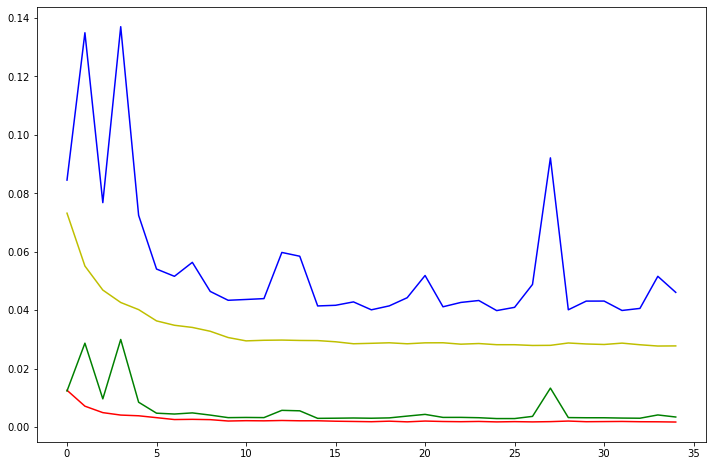

In [16]:
plt.figure(figsize=(12,8))
plt.plot(history.history['loss'], c='r')
plt.plot(history.history['val_loss'], c='g')
plt.plot(history.history['mae'], c='y' )
plt.plot(history.history['val_mae'], c='b')
plt.show()

In [17]:
pred = model.predict(x_test)
pred

array([[ 0.39921802],
       [ 0.3925514 ],
       [ 0.32119188],
       [ 0.27560914],
       [ 0.28831574],
       [ 0.25873503],
       [ 0.2589557 ],
       [ 0.2651793 ],
       [ 0.16474706],
       [ 0.1344328 ],
       [ 0.23240644],
       [ 0.3179275 ],
       [ 0.29156923],
       [ 0.32891247],
       [ 0.41588125],
       [ 0.28353626],
       [ 0.3052222 ],
       [ 0.34973326],
       [ 0.57654345],
       [ 0.52774405],
       [ 0.3173491 ],
       [ 0.17345162],
       [ 0.22981688],
       [ 0.22235519],
       [ 0.14322731],
       [ 0.0892022 ],
       [ 0.07798629],
       [ 0.14120567],
       [ 0.08992639],
       [ 0.12901768],
       [ 0.1079099 ],
       [ 0.1598024 ],
       [ 0.17498714],
       [ 0.16112253],
       [ 0.184697  ],
       [ 0.1292234 ],
       [ 0.09989843],
       [ 0.20176259],
       [ 0.27500978],
       [ 0.3071512 ],
       [ 0.49490306],
       [ 0.42265278],
       [ 0.46897376],
       [ 0.40176216],
       [ 0.35157427],
       [ 0

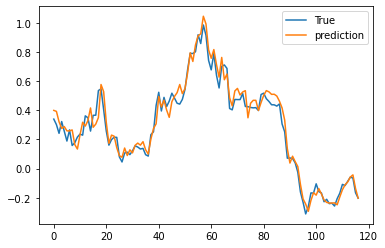

In [18]:
fig = plt.figure(facecolor='white')
ax = fig.add_subplot(1,1,1)
ax.plot(y_test,label='True')
ax.plot(pred, label='prediction')
ax.legend()
plt.show()

In [19]:
# 미래 코인가격을 예측하는 함수
def predictCoin(prices):
    r_price = []
    p_price = []
    for v in range(100,0,-1):
        r_price.append(prices[-50-v:-v])
    for i in range(200):
        # 데이터 정규화
        pre_test = []
        normalized_window = [float(p)/float(r_price[i][0])for p in r_price[i]]
        pre_test.append(normalized_window)
        test = np.array(pre_test)
        pre_test = test[:,:]
        pre_test = np.reshape(pre_test, (pre_test.shape[0], pre_test.shape[1],1))
        # 가격 예측 후 원래 데이터셋에 추가(예측 가격은 p_price)
        pre_result = model.predict(pre_test)
        p = pre_result[0]
        p = round(r_price[i][0]*p[0],2)
        p_price.append(p)
        if( i >= 99 ):
            new_price = np.array([])
            new_price = np.append(r_price[i][1:],p)
            r_price.append(new_price)
        print(i)
    return p_price

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199


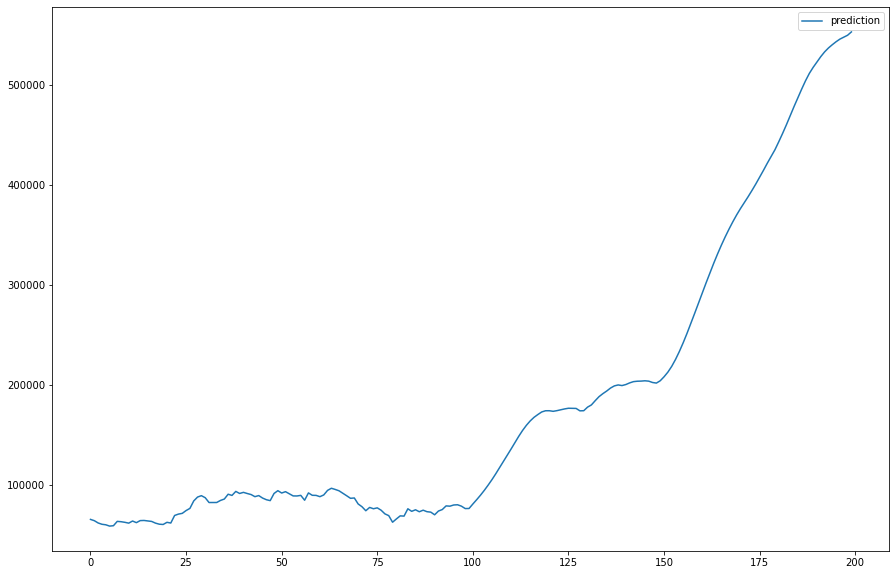

In [20]:
predictC = predictCoin(prices)

fig = plt.figure(facecolor='white',figsize=(15,10))
ax = fig.add_subplot(1,1,1)
ax.plot(predictC, label='prediction')
ax.legend()
plt.show()

In [21]:
predictC

[65498.27,
 64227.22,
 61943.4,
 60631.18,
 60119.57,
 58818.5,
 59193.93,
 63529.02,
 63190.88,
 62580.38,
 61768.33,
 63874.29,
 62256.51,
 64298.09,
 64447.44,
 63978.22,
 63465.12,
 61778.74,
 60704.78,
 60432.85,
 62582.72,
 61872.95,
 69433.16,
 70806.09,
 71536.39,
 74333.49,
 76508.34,
 83952.92,
 87819.45,
 89209.67,
 87187.37,
 82366.5,
 82380.72,
 82393.31,
 84457.79,
 85839.41,
 90650.57,
 89465.71,
 93473.53,
 91412.58,
 92521.15,
 91365.34,
 90331.41,
 88217.27,
 89306.58,
 86828.78,
 85169.98,
 84261.79,
 91391.94,
 94200.34,
 91857.65,
 93207.81,
 91097.25,
 88968.17,
 88918.24,
 89506.34,
 84645.78,
 91962.78,
 89588.62,
 89494.6,
 88222.36,
 89924.99,
 94491.3,
 96611.39,
 95428.79,
 94075.82,
 91659.69,
 89123.55,
 86580.95,
 86903.01,
 80923.16,
 78173.94,
 74158.42,
 77471.08,
 76147.71,
 77034.47,
 74695.87,
 71027.96,
 69265.83,
 62694.32,
 65957.54,
 69029.1,
 68786.32,
 76116.45,
 73568.65,
 75109.4,
 73153.04,
 74712.3,
 73202.43,
 72758.06,
 70104.34,
 73853.